In [72]:
# encoding: utf-8
import numpy as np
import matplotlib.pyplot as plt

# Cam-clay critical state parameters
pc_0 = 150.0  # 'Initial consolidation pressure [kPa]'
M = 0.95  # 'Critical friction angle'
lambda_val = 0.2  # 'Lambda'
kappa = 0.04  # 'kappa'
N = 2.5  # 'Intercept of the normal consolidation line'
nu = 0.15  # 'Poisson ratio'

# Initial conditions
p0 = 150.0  # 'Initial confining pressure [kPa]'
V = N - (lambda_val * np.log(pc_0)) + (kappa * np.log(pc_0 / p0))  # Specific Volume
void_ratio_0 = V - 1  # Initial void ratio
Phi_0 = 1.0 / (1.0 + void_ratio_0)  # Initial solid volume fraction
deformation_mode = 'drained'
#deformation_mode = 'undrained'

# Maximum shear strain and number of load steps for the quasi-static stage
eqp_tot = 100.0  # [%] 'total plastic shear strain'
time = 100.0  # [s] 'second'
load_length = int(1e5)+1  # [-] 'loadsteps'
dt = time / load_length

# Collisional contribution parameters
Delta_Phi = 4e-4
M_c = 1.8

# Define a loading history
eqp_inc = eqp_tot / (1e2 * load_length)  # [-] 'incrementl applied plastic shear strain'
eqp_inc_history = np.concatenate([
    np.ones(round(1.0 / eqp_inc)) * eqp_inc,
    np.linspace(eqp_inc, 100 * eqp_inc, round(0.5 / eqp_inc)),
    np.ones(round(1.0 / eqp_inc)) * 100 * eqp_inc,
    np.linspace(100 * eqp_inc, eqp_inc, round(0.5 / eqp_inc)),
    np.ones(round(0.5 / eqp_inc)) * eqp_inc,
])
load_length = eqp_inc_history.shape[0]

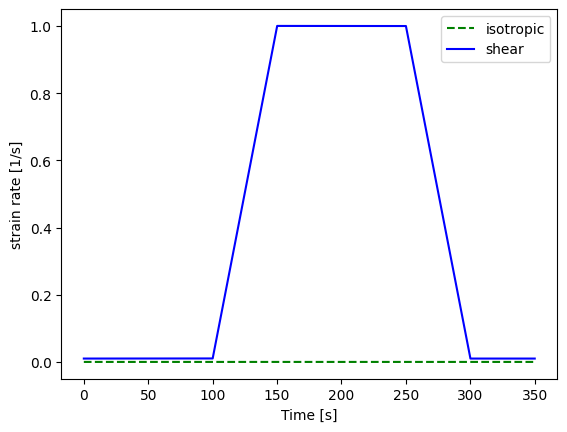

In [73]:
plt.figure('Load history')
plt.plot(np.arange(load_length) * dt, np.zeros(load_length), '--g',label='isotropic')
plt.plot(np.arange(load_length) * dt, eqp_inc_history / dt, '-b',label='shear')
plt.xlabel('Time [s]')
plt.ylabel('strain rate [1/s]')
plt.legend()

In [74]:
# Declarations
void_ratio_total = np.zeros(load_length)
void_ratio_q = np.zeros(load_length)
p = np.zeros(load_length)
q = np.zeros(load_length)
u = np.zeros(load_length)
ev = np.zeros(load_length)
eq = np.zeros(load_length)
d_p_c = np.zeros(load_length)
p_c = np.zeros(load_length)
q_c = np.zeros(load_length)
p_total = np.zeros(load_length)
q_total = np.zeros(load_length)
pc_history = np.zeros(load_length)

# Derived parameters
OCR = pc_0 / p0  # Over Consolidation Ratio

# Initialize state variables
K_c = 0
G_c = 0
pc = pc_0
p[0] = p0
p_total[0] = p0
sigma = np.array([p0, p0, p0, 0.0, 0.0, 0.0])
epsilon = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
de_v_c = 0
de_q_direction = np.zeros(6)
void_ratio_total[0] = void_ratio_0
void_ratio_q[0] = void_ratio_0

# Initialize the yield surf surface
yield_surf = (q[0] ** 2 / M ** 2 + p[0] ** 2) - p[0] * pc

In [75]:
# Loadstep cycle pressure control shear
for i, eqp_inc in enumerate(eqp_inc_history[:-1]):
    
    ioutstep=10000
    if( i%ioutstep == 0 ): print(" %d " %i, end=' ')
        
    # Acceleration increment
    d_eqp_inc = eqp_inc - eqp_inc_history[i - 1] if i > 0 else 0

    # Stiffness matrix and strain increment vector and derivatives of the yield function
    De = np.zeros([6, 6])
    # TODO: HC: check if the stiffness matrix for collisional stress increments can be formulated like elasticity
    Dc = np.zeros([6, 6])
    df_ds = np.zeros([6, 1])
    df_dep = np.zeros([6, 1])

    # Calculate the bulk and shear modulus
    K = V * p[i] / kappa  # Bulk Modulus
    G = (3 * K * (1 - 2 * nu)) / (2 * (1 + nu))  # Shear Modulus

    # Update pre-consolidation pressure
    if yield_surf == 0:
        pc = (q[i] ** 2 / M ** 2 + p[i] ** 2) / p[i]
    else:
        pc = pc_0
    pc_history[i + 1] = pc

    # Elastic Stiffness and other Matrix
    # Get the quasi-static stress tensor by taking the difference between the total `sigma' and the collisional stress
    sigma_q = sigma - p_c[i] * np.array([1., 1., 1., 0, 0, 0]) - p_c[i] * M_c * de_q_direction
    for m in range(6):
        for n in range(6):
            if m <= 2:
                if yield_surf < 0:
                    df_ds[m, 0] = 0
                    df_dep[m, 0] = 0
                else:
                    df_ds[m, 0] = (2 * p[i] - pc) / 3 + 3 * (sigma_q[m] - p[i]) / M ** 2
                    df_dep[m, 0] = (-p[i]) * pc * (1 + void_ratio_q[i]) / (lambda_val - kappa) * 1
                if m == n:
                    De[m, n] = K + 4 / 3 * G
                    Dc[m, n] = K_c + 4 / 3 * G_c
                elif n <= 2:
                    De[m, n] = K - 2 / 3 * G
                    Dc[m, n] = K_c - 2 / 3 * G_c
            if m > 2:
                df_ds[m, 0] = 0
                df_dep[m, 0] = 0
                if m == n:
                    De[m, n] = G
                    Dc[m, n] = G_c
                else:
                    De[m, n] = 0
                    Dc[m, n] = 0

        # If the yield surface is negative, the stiffness matrix is elastic
        if yield_surf < 0:
            D = De
        # If the yield surface is positive, the stiffness matrix is elastic-plastic
        else:
            D = De - (De.dot(df_ds).dot(df_ds.T).dot(De)) / (
                    -(df_dep.T).dot(df_ds) + (df_ds.T).dot(De).dot(df_ds)) + Dc

    # Fill the strain increment vector
    if deformation_mode == 'drained':
        # For drained (or pressure control) conditions
        d_epsilon = np.array(
            [eqp_inc, - D[1, 0] / (D[1, 1] + D[1, 2]) * eqp_inc, - D[2, 0] / (D[2, 1] + D[2, 2]) * eqp_inc, 0., 0., 0.])
    elif deformation_mode == 'undrained':
        d_epsilon = np.array(
            [eqp_inc, -eqp_inc / 2., -eqp_inc / 2., 0., 0., 0.])

    # Get the direction of the deviatoric strain
    de_v = np.sum(d_epsilon[:3])
    de_q = d_epsilon - np.array([1., 1., 1., 0, 0, 0]) * de_v
    de_q_norm = np.sqrt(3. / 2. * de_q.dot(de_q))
    de_q_direction = de_q / de_q_norm

    # Calculate collisional stress
    if d_eqp_inc != 0:
        # Get sign of the acceleration rate, positive: accelerate; negative decelerate.
        # Now simplified as sign(d_eqp_inc). Should have been the sign between de_q_direction and e_q_direction tensors
        sign = np.sign(d_eqp_inc * eq[i])

        Phi = 1.0 / (1.0 + void_ratio_q[i])
        de_v_c = - Phi_0 / Phi ** 2 * Delta_Phi * sign * de_q_norm
        d_p_c[i + 1] = p_total[i] / (lambda_val * Phi ** 2) * Delta_Phi * sign * de_q_norm

        K_c = d_p_c[i + 1] / de_v_c
        G_c = d_p_c[i + 1] * M_c / de_q_norm
        p_c[i + 1] = p_c[i] + d_p_c[i + 1]
        q_c[i + 1] = q_c[i] + d_p_c[i + 1] * M_c
    else:
        p_c[i + 1] = p_c[i]
        q_c[i + 1] = q_c[i]
        K_c = 0
        G_c = 0

    # Update stress
    d_sigma = D.dot(d_epsilon)
    sigma += d_sigma  # + d_p_c[i + 1] * np.array([1., 1., 1., 0, 0, 0]) + d_p_c[i + 1] * M_c * de_q_direction
    epsilon += d_epsilon  # + 1. / 3 * de_v_c * np.array([1., 1., 1., 0, 0, 0])
    # Update stress invariants
    p_total[i + 1] = np.sum(sigma[:3]) / 3.0
    p_s = sigma - np.array([1., 1., 1., 0, 0, 0]) * p_total[i + 1]
    q_total[i + 1] = np.sqrt(3. / 2. * p_s.dot(p_s))

    # Compute stress and strain invariants
    ev[i + 1] = np.sum(epsilon[:3])
    epsilon_s = epsilon - np.array([1, 1, 1, 0, 0, 0]) * ev[i + 1]
    eq[i + 1] = np.sqrt(2. / 3. * epsilon_s.dot(epsilon_s))

    p[i + 1] = p_total[i + 1] - p_c[i + 1]
    q[i + 1] = q_total[i + 1] - q_c[i + 1]
    u[i + 1] = p0 + q_total[i + 1] / 3. - p_total[i + 1]

    # Update specific volume
    V = N - (lambda_val * np.log(pc)) + (kappa * np.log(pc / p[i + 1]))
    void_ratio_q[i + 1] = V - 1
    void_ratio_total[i + 1] = void_ratio_0 - (1 + void_ratio_0) * ev[i + 1]

    if yield_surf < 0:
        yield_surf = q[i + 1] ** 2 + M ** 2 * p[i + 1] ** 2 - M ** 2 * p[i + 1] * pc
    else:
        yield_surf = 0

 0   10000   20000   30000   40000   50000   60000   70000   80000   90000   100000   110000   120000   130000   140000   150000   160000   170000   180000   190000   200000   210000   220000   230000   240000   250000   260000   270000   280000   290000   300000   310000   320000   330000   340000   350000  

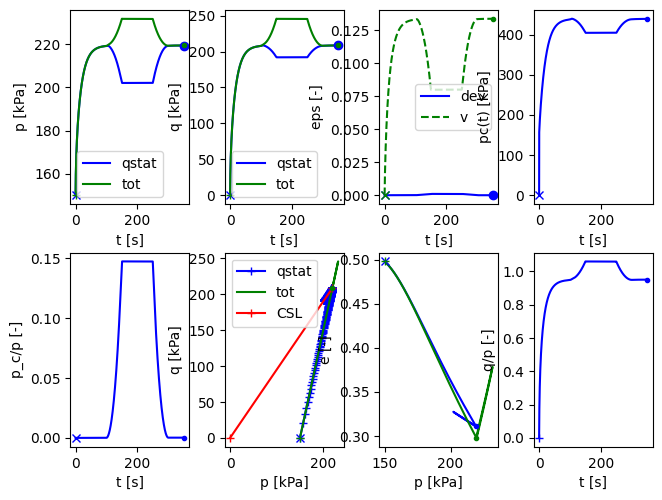

In [76]:
# Display results
plt.figure('Pressure controlled simple shear')

# Full text long labels
ctime='Time [s]'
cmu='Stress ratio q/p [-]'
cp='Volumetric stress p [kPa]'
cq='Deviatoric stress q [kPa]'
cev='Volumetric strain [-]'
cppc='pre-consolidation pressure [kPa]'
cpcoll='coll. volumetric stress / p [-]'
cvr='Void ratio [-]'

# Symbolic short labels
ctime='t [s]'
cmu='q/p [-]'
cp='p [kPa]'
cq='q [kPa]'
cev='eps [-]'
cppc='pc(t) [kPa]'
cpcoll='p_c/p [-]'
cvr='e [-]'

# pressure vs. time
plt.subplot(2, 4, 1)
plt.plot(np.arange(load_length) * dt, p, '-b', label='qstat')
plt.plot(np.arange(load_length) * dt, p_total, '-g', label='tot')
# begin and endpoints
plt.plot(0 * dt, p[0], 'bx', label='')
plt.plot(0 * dt, p_total[0], 'g+', label='')
plt.plot(load_length * dt, p[-1], 'bo', label='')
plt.plot(load_length * dt, p_total[-1], 'g.', label='')
# labels
plt.xlabel(ctime)
plt.ylabel(cp)
plt.legend()

# deviatoric stress (q) vs. time
plt.subplot(2, 4, 2)
plt.plot(np.arange(load_length) * dt, q, '-b', label='qstat')
plt.plot(np.arange(load_length) * dt, q_total, '-g', label='tot')
# begin and endpoints
plt.plot(0 * dt, q[0], 'bx', label='')
plt.plot(0 * dt, q_total[0], 'g+', label='')
plt.plot(load_length * dt, q[-1], 'bo', label='')
plt.plot(load_length * dt, q_total[-1], 'g.', label='')
# labels
plt.xlabel(ctime)
plt.ylabel(cq)
plt.legend()

# volumetric and deviatoric strain vs. time
plt.subplot(2, 4, 3)
plt.plot(np.arange(load_length) * dt, eqp_inc_history, '-b',label='dev')
plt.plot(np.arange(load_length) * dt, ev, '--g',label='v')
# begin and endpoints
plt.plot(0 * dt, eqp_inc_history[0], 'bx', label='')
plt.plot(0 * dt, ev[0], 'gx', label='')
plt.plot(load_length * dt, eqp_inc_history[-1], 'bo', label='')
plt.plot(load_length * dt, ev[-1], 'g.', label='')
# labels
plt.xlabel(ctime)
plt.ylabel(cev)
plt.legend()

# pre-consolidation pressure vs. time
plt.subplot(2, 4, 4)
plt.plot(np.arange(load_length) * dt, pc_history, '-b')
# begin and endpoints
plt.plot(0 * dt, pc_history[0], 'bx', label='')
plt.plot(load_length * dt, pc_history[-1], 'b.', label='')
# labels
plt.xlabel(ctime)
plt.ylabel(cppc)

# collisional stress (iso) vs. time
plt.subplot(2, 4, 5)
plt.plot(np.arange(load_length) * dt, p_c/p, '-b')
# begin and endpoints
plt.plot(0 * dt, p_c[0]/p[0], 'bx', label='')
plt.plot(load_length * dt, p_c[-1]/p[-1], 'b.', label='')
# labels
plt.xlabel(ctime)
plt.ylabel(cpcoll)

# deviatoric stress vs. p
plt.subplot(2, 4, 6)
imark=500
plt.plot(p, q, '-+b', markevery=imark, label='qstat')
plt.plot(p_total, q_total, '-g', label='tot')
plt.plot([0, np.max(p)], [0, M * np.max(p)], '-+r', label='CSL')
# begin and endpoints
plt.plot(p[0], q[0], 'bx', label='')
plt.plot(p[0], q_total[0], 'g+', label='')
#plt.plot(p[0], 0, 'r*', label='')
plt.plot(p_total[-1], q[-1], 'b.', label='')
plt.plot(p_total[-1], q_total[-1], 'g.', label='')
#plt.plot(p_total[-1], M * np.max(p), 'rs', label='')
# labels
plt.xlabel(cp)
plt.ylabel(cq)
plt.legend()

# void ratios vs. p
plt.subplot(2, 4, 7)
plt.plot(p, void_ratio_q, '-b', label='qstat')
plt.plot(p_total, void_ratio_total, '-g', label='tot')
# begin and endpoints
plt.plot(p[0], void_ratio_q[0], 'bx', label='')
plt.plot(p_total[0], void_ratio_total[0], 'g+', label='')
plt.plot(p[-1], void_ratio_q[-1], 'b.', label='')
plt.plot(p_total[-1], void_ratio_total[-1], 'g.', label='')
# labels
plt.xlabel(cp)
plt.ylabel(cvr)
#plt.legend()

# bulk friction vs. time
plt.subplot(2, 4, 8)
plt.plot(np.arange(load_length) * dt, q_total / p_total, 'b')
# begin and endpoints
plt.plot(0 * dt, q_total[0]/p_total[0], 'b+', label='')
plt.plot(load_length * dt, q_total[-1]/p_total[-1], 'b.', label='')
# labels
plt.xlabel(ctime)
plt.ylabel(cmu)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.subplots_adjust(hspace=0.25, wspace=0.3, top=0.97, right=0.97, left=0.06, bottom=0.06)
plt.show()

In [55]:
void_ratio_q[-5:-1]

array([0.3108676, 0.3108676, 0.3108676, 0.3108676])